# EXPERIMENT 5: Thresholds

In [2]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import seaborn as sns
import pandas as pd
import numpy as np
from src.dataset import AfricanWildlifeDataset
from src.loss import YoloLoss
from src.YOLOv1 import YOLO
from src.train import train
from src.test import test
from src.utils import plot_bbox, get_boxes, convert_dict
import time
from tqdm import tqdm

In [3]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
torch.device('cuda')
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 5
EPOCHS = 0
TRAIN_DIR = 'African_Wildlife/train'
TEST_DIR = 'African_Wildlife/test'
LABEL_DIR = 'African_Wildlife/annotations'
S, B, C = 7, 2, 4

In [4]:
# load the data
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor(), transforms.Normalize([0.5200, 0.4957, 0.4068],[0.2391, 0.2283, 0.2303])])

train_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, transform=transform)
train_loader = DataLoader(dataset = train_set, batch_size = TRAIN_BATCH_SIZE, shuffle = True)

test_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, istesting=True, transform=transform)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, shuffle= False)

In [6]:
# model
model = YOLO(input_channels=3, S=S, B=B, C=C, fc=2).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss(S=S, B=B, C=C)

In [7]:
start_time = time.time()
loss_hist = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE,
                  ckpt_filename='experiment_1/paper_config.tar', load_model=True, 
                  save_epochs=5)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 

-> Loading checkpoint
Elapsed time:  2.533757209777832


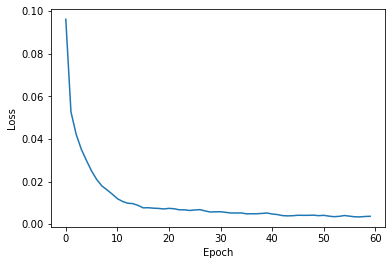

In [8]:
import matplotlib.pyplot as plt

exp = torch.load('experiment_1/paper_config.tar')
loss_history = exp["loss_history"]
plt.plot(range(len(loss_history)), loss_history) # trained for 60 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [9]:
thresholds = [round(x.item(), 2) for x in torch.arange(0.5, 0.95, 0.05)]
aps = []

loop = tqdm(thresholds, leave=True)
for t in loop:
    # testing 
    y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[t, True])
    # non-max-suppression
    pred_boxes, true_boxes = get_boxes(y_pred, y_true, iou_threshold=0.5)

    pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
    for box in pred_boxes:
        pred[box[0]].append(box[1:])
    # map
    gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
    for box in true_boxes:
        gt[box[0]].append(box[1:])

    predictions = convert_dict(pred)
    target = convert_dict(gt, with_score=False)

    th = [round(x.item(), 2) for x in torch.arange(0.5, 1, 0.05)]
    m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
    m_ap.update(predictions, target)
    ap = m_ap.compute()
    aps.append(ap['map'])

 11%|█         | 1/9 [00:16<02:08, 16.04s/it]

tensor(0.1337)


 22%|██▏       | 2/9 [00:23<01:18, 11.21s/it]

tensor(0.1279)


 33%|███▎      | 3/9 [00:31<00:56,  9.49s/it]

tensor(0.1090)


 44%|████▍     | 4/9 [00:38<00:42,  8.55s/it]

tensor(0.0797)


 56%|█████▌    | 5/9 [00:45<00:32,  8.02s/it]

tensor(0.0524)


 67%|██████▋   | 6/9 [00:52<00:23,  7.68s/it]

tensor(0.0126)


 78%|███████▊  | 7/9 [00:59<00:14,  7.45s/it]

tensor(0.)


 89%|████████▉ | 8/9 [01:06<00:07,  7.35s/it]

tensor(0.)


100%|██████████| 9/9 [01:13<00:00,  8.20s/it]

tensor(0.)


Text(0.5, 1.0, 'confidence score thresholds vs mAP')

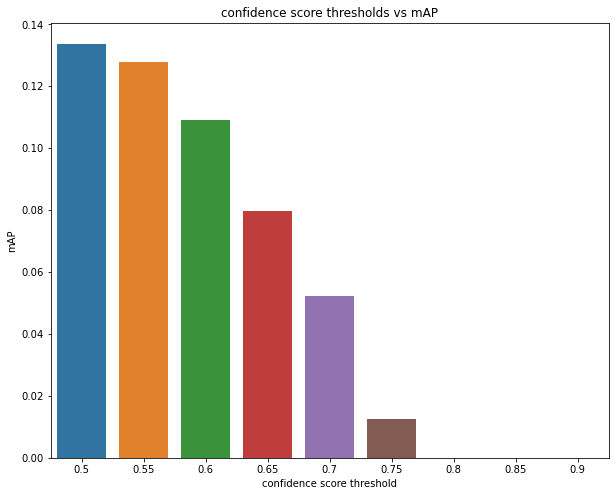

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
df = pd.DataFrame(data=np.array([thresholds, aps]).T, columns=['confidence score threshold', 'mAP'])
sns.barplot(data=df, x='confidence score threshold', y='mAP')
ax.set_title('confidence score thresholds vs mAP')

In [11]:
thresholds = [round(x.item(), 2) for x in torch.arange(0.1, 0.95, 0.05)]
aps = []

loop = tqdm(thresholds, leave=True)
for t in loop:
    # testing 
    y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.6, True])
    # non-max-suppression
    pred_boxes, true_boxes = get_boxes(y_pred, y_true, iou_threshold=t)

    pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
    for box in pred_boxes:
        pred[box[0]].append(box[1:])
    # map
    gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
    for box in true_boxes:
        gt[box[0]].append(box[1:])

    predictions = convert_dict(pred)
    target = convert_dict(gt, with_score=False)

    th = [round(x.item(), 2) for x in torch.arange(0.5, 1, 0.05)]
    m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
    m_ap.update(predictions, target)
    ap = m_ap.compute()
    aps.append(ap['map'])

100%|██████████| 17/17 [03:41<00:00, 13.01s/it]


Text(0.5, 1.0, 'Non-max suppression IoU threshold vs mAP')

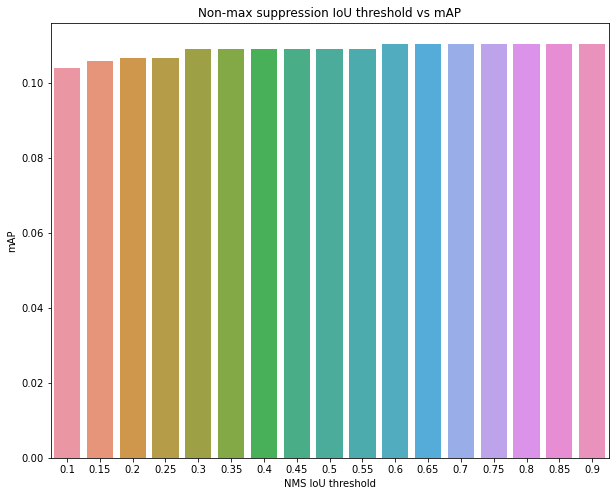

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
df = pd.DataFrame(data=np.array([thresholds, aps]).T, columns=['NMS IoU threshold', 'mAP'])
sns.barplot(data=df, x='NMS IoU threshold', y='mAP')
ax.set_title('Non-max suppression IoU threshold vs mAP')

In [ ]:
iou_thresholds = [round(x.item(), 2) for x in torch.arange(0.1, 0.95, 0.05)]
thresholds = [round(x.item(), 2) for x in torch.arange(0.5, 0.95, 0.05)]
aps = {}

loop = tqdm(iou_thresholds, leave=True)
for t in loop:
    for iou in iou_thresholds:
        # testing 
        y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[t, True])
        # non-max-suppression
        pred_boxes, true_boxes = get_boxes(y_pred, y_true, iou_threshold=iou)

        pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
        for box in pred_boxes:
            pred[box[0]].append(box[1:])
        # map
        gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
        for box in true_boxes:
            gt[box[0]].append(box[1:])

        predictions = convert_dict(pred)
        target = convert_dict(gt, with_score=False)

        th = [round(x.item(), 2) for x in torch.arange(0.5, 1, 0.05)]
        m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
        m_ap.update(predictions, target)
        ap = m_ap.compute()
        aps[t, iou] = ap['map']

In [ ]:
np.hstack([np.array([str(key) for key in aps.keys()]), np.array(aps.values())]).shape

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
df = pd.DataFrame(data=np.array([np.array([str(key) for key in aps.keys()]), np.array(aps.values())]), columns=['thresholds', 'mAP'])
sns.barplot(data=df, x='threshold', y='mAP')
ax.set_title('thresholds vs mAP')

In [ ]:
keys = sorted(aps, key=lambda x: aps[x])
values = [aps[x] for x in keys]
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.scatter([str(x) for x in keys], values)
ax.set_yticks([float(x) for x in values])

In [ ]:
keys[-9:]


In [ ]:
thresholds = [round(x.item(), 2) for x in torch.arange(0.5, 0.95, 0.05)]
aps = []

loop = tqdm(thresholds, leave=True)
for t in loop:
    # testing 
    y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[t, True])
    # non-max-suppression
    pred_boxes, true_boxes = get_boxes(y_pred, y_true, iou_threshold=0.5)

    pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
    for box in pred_boxes:
        pred[box[0]].append(box[1:])
    # map
    gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
    for box in true_boxes:
        gt[box[0]].append(box[1:])

    predictions = convert_dict(pred)
    target = convert_dict(gt, with_score=False)

    th = [round(x.item(), 2) for x in torch.arange(0.5, 1, 0.05)]
    m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
    m_ap.update(predictions, target)
    ap = m_ap.compute()
    print(ap['map'])
    aps.append(ap['map'])

In [ ]:
# testing 
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.60, True])
# non-max-suppression
pred_boxes, true_boxes = get_boxes(y_pred, y_true, iou_threshold=0.5)

pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

In [ ]:
# plot predictions
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [ ]:
# map
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])
    
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
m_ap.update(predictions, target)
ap1 = m_ap.compute()

In [ ]:
ap1